## 基于Backtrader的量化回测教程

### 使用Akshare作为数据源，对股票做策略回测

### 1.安装依赖

In [1]:
# !pip install tushare==1.2.85
# !pip install akshare -U
# !pip install backtrader==1.9.76.123
# !pip install pandas==1.5.2 --user

### 2.导入相关的Python库

In [2]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib notebook

### 3.设置回测参数

In [3]:
start_date = '20150101'
end_date = '20230101'
symbol = '000001' #平安银行

In [4]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
print(stock_zh_a_hist_df)

              日期       开盘       收盘       最高       最低      成交量           成交额  \
0     2015-01-05  1797.18  1800.57  1829.92  1753.17  2860436  4.565388e+09   
1     2015-01-06  1781.38  1773.48  1842.33  1747.52  2166421  3.453446e+09   
2     2015-01-07  1748.65  1739.62  1779.13  1719.31  1700121  2.634796e+09   
3     2015-01-08  1741.88  1680.93  1749.78  1674.16  1407714  2.128003e+09   
4     2015-01-09  1674.16  1694.48  1783.64  1652.72  2508500  3.835378e+09   
...          ...      ...      ...      ...      ...      ...           ...   
1942  2022-12-26  2317.14  2281.38  2325.26  2271.63   797120  1.021904e+09   
1943  2022-12-27  2297.63  2336.64  2354.52  2297.63   886004  1.160090e+09   
1944  2022-12-28  2344.77  2341.52  2380.52  2318.76   791192  1.042402e+09   
1945  2022-12-29  2330.14  2323.64  2339.89  2294.38   666890  8.651450e+08   
1946  2022-12-30  2325.26  2344.77  2364.27  2312.26   818036  1.074757e+09   

        振幅   涨跌幅    涨跌额   换手率  
0     4.31  1.14  2

In [5]:
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume'},inplace=True)
stock_zh_a_hist_df = stock_zh_a_hist_df[['date','open','high','low','close','volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
#stock_zh_a_hist_df.sort_values(by='date', inplace=True)
stock_zh_a_hist_df

,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500
...,...,...,...,...,...,...
1942,2022-12-26,2317.14,2325.26,2271.63,2281.38,797120
1943,2022-12-27,2297.63,2354.52,2297.63,2336.64,886004
1944,2022-12-28,2344.77,2380.52,2318.76,2341.52,791192
1945,2022-12-29,2330.14,2339.89,2294.38,2323.64,666890


### 4.编写策略类

In [6]:
class MACDStrategy(bt.Strategy):
    params = (
        ('fast_period', 12),
        ('slow_period', 26),
        ('signal_period', 9),
    )
    
    def __init__(self):
        self.macd = bt.indicators.MACD(
            self.data.close,                    #self.datas[0]
            period_me1=self.params.fast_period,
            period_me2=self.params.slow_period,
            period_signal=self.params.signal_period,
        )
    
    def next(self):
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)
        if self.macd.macd[0] > self.macd.signal[0] and self.macd.macd[-1] <= self.macd.signal[-1]:
            self.buy(size=size)
        elif self.macd.macd[0] < self.macd.signal[0] and self.macd.macd[-1] >= self.macd.signal[-1]:
            self.close()

### 5.开始回测

In [7]:
#创建回测引擎对象
cerebro = bt.Cerebro()

In [8]:
stock_data = PandasData(
                dataname=stock_zh_a_hist_df,
                datetime=0, # 日期列
                open=1, # 开盘价所在列
                high=2, # 最高价所在列
                low=3, # 最低价所在列
                close=4, #收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'), # 起始日 dt.striptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'), # 结束日
            )
    

In [9]:
cerebro.adddata(stock_data, name='stock')

In [10]:
start_cash=1000000

In [11]:
cerebro.addstrategy(MACDStrategy)

0

In [12]:
cerebro.broker.setcash(start_cash)

In [13]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

In [14]:
print('初始市值： %.2f' % cerebro.broker.getvalue())

初始市值： 1000000.00


In [15]:
results = cerebro.run()
strat = results[0]

In [16]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

In [17]:
returns.index=returns.index.tz_convert(None)
print('最终市值： %.2f' % cerebro.broker.getvalue())

最终市值： 1083486.00


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             51.0%

Cumulative Return          8.35%
CAGR﹪                     0.7%

Sharpe                     0.15
Prob. Sharpe Ratio         66.09%
Smart Sharpe               0.14
Sortino                    0.23
Smart Sortino              0.22
Sortino/√2                 0.16
Smart Sortino/√2           0.15
Omega                      1.04

Max Drawdown               -37.71%
Longest DD Days            905
Volatility (ann.)          18.88%
Calmar                     0.02
Skew                       0.86
Kurtosis                   10.82

Expected Daily %           0.0%
Expected Monthly %         0.08%
Expected Yearly %          1.01%
Kelly Criterion            1.83%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.95%
Expected Shortfall (cVaR)  -1.95%

Max Consecutive Wins       7
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-05-28,2015-09-29,2017-11-17,905,-37.706000,-35.918000
2,2017-11-23,2018-10-29,2020-01-02,771,-35.283331,-34.416019
3,2021-08-19,2022-06-13,2022-12-30,499,-31.908831,-31.070105
4,2020-01-06,2020-06-15,2020-07-03,180,-11.009575,-10.162462
5,2020-07-09,2020-09-03,2020-10-22,106,-10.531733,-10.354261


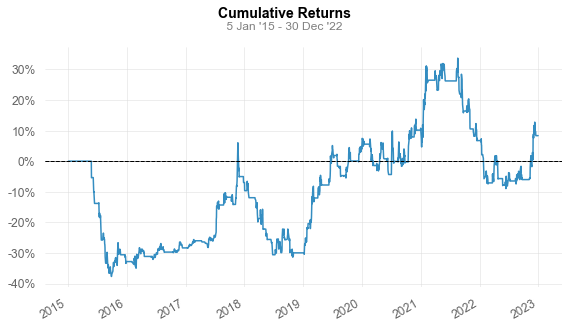

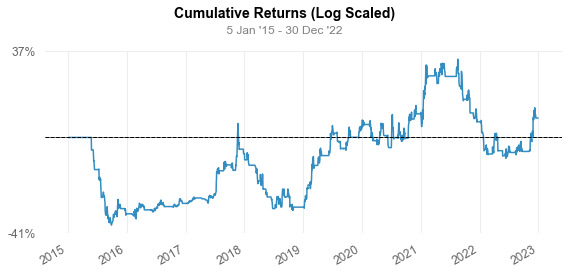

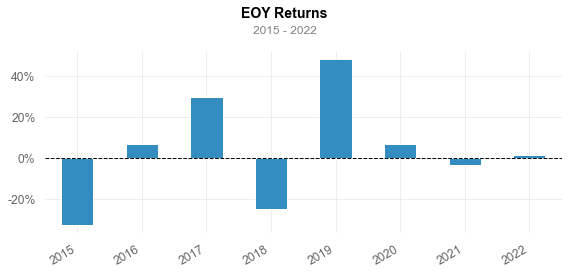

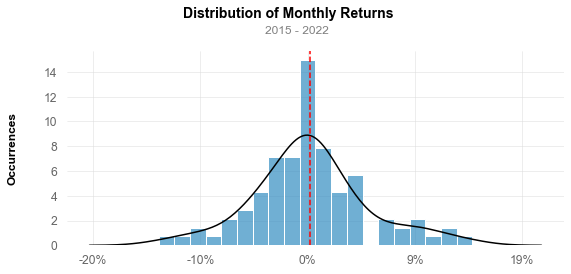

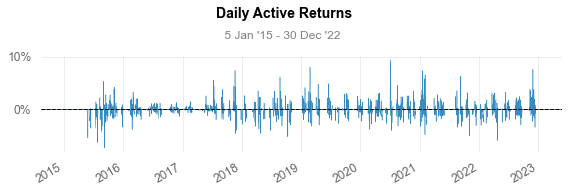

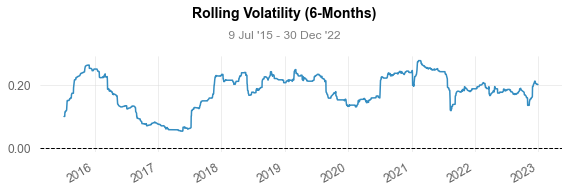

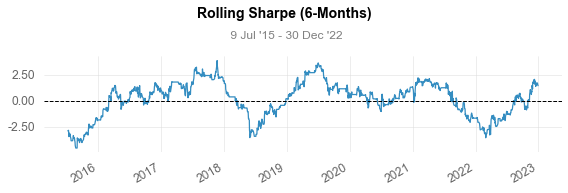

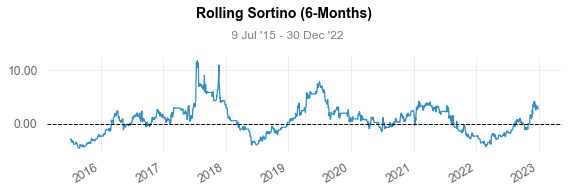

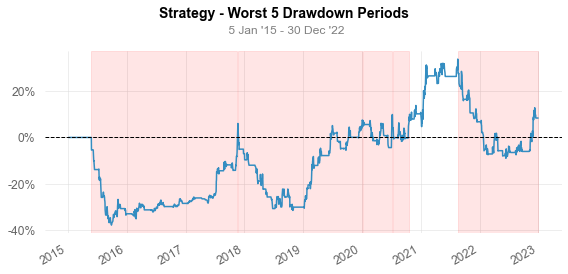

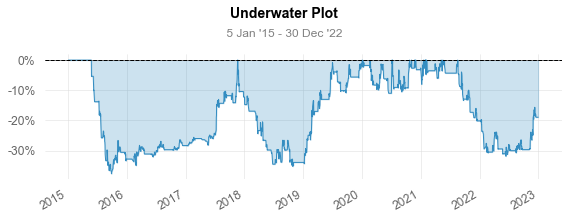

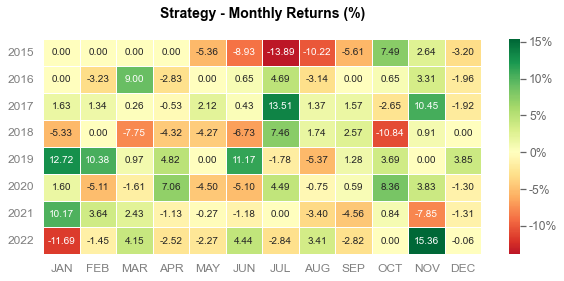

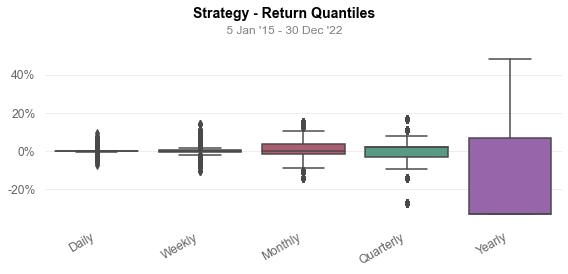

In [18]:
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)

### 在进行股票量化回测时，需要注意以下几个方面：

- 数据来源：回测的结果很大程度上取决于使用的数据来源。因此，需要使用高质量、可靠的数据源，如官方数据或专业数据提供商的数据。
- 数据清洗：在使用数据进行回测之前，需要对数据进行清洗和预处理，以去除异常值、缺失值等数据问题，保证数据的完整性和准确性。
- 时间跨度：回测的时间跨度需要考虑到市场的变化和周期性，尽量选择长期的时间跨度，覆盖多个市场周期。
- 策略选择：需要根据自己的投资风格和市场状况选择合适的策略。不同的策略适用于不同的市场环境和投资风格，需要根据实际情况进行选择。
- 参数优化：在使用策略进行回测时，需要对测量参数进行优化，以寻找最优的参数组合。但是需要注意，过度拟合参数可能会导致过度优化，对未来的表现产生负面影响。
- 交易成本：回测时需要考虑交易成本， 如手续费、印花税等，以确保回测结果的真实性和可靠性。
- 风险控制：需要在回测中加入风险控制策略，如止损、止盈等，以避免过度风险和损失。

股票量化回测需要综合考虑多个因素，包括数据来源、数据清洗、时间跨度、策略选择、参数优化、交易成本和风险控制等，才能得出可靠的回测结果。
